In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   datetime import timedelta
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import oceanlyz
import matplotlib.pylab as pl
from scipy import signal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seawater as sw

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=13
mpl.rcParams['ytick.labelsize']=13
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_mat_files(Test, file_name, Folder_variable):
    """
    INPUTS: 
    - Test: # Name of test folder (ej: TESTx)
    - file_name: Name of file to upload
    - Folder_variable: Name of variable of data (
        - Velocity
        - Water_level
        - Wave
        - Salinity_Temperature
    )
    ------------------------------------------------------------------------
    OUTPUT:
    - Dictionary of data
    """
    path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
    prop_mat_data = mat73.loadmat(path+'\\'+Test+'\\'+Folder_variable+'\\'+file_name)
    dic_data = prop_mat_data['data']
    return dic_data

def angulo_norte(x,y):
    if x > 0 and y > 0:
        theta = 90 - (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y > 0:
        theta = 270 + (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y < 0:
        theta = 270 - (np.arctan(abs(y/x))*(180/np.pi))
    else:
        theta = 90 + (np.arctan(abs(y/x))*(180/np.pi))
    return theta

# FIELD DATA 
- Currents
    - Velocity profiles
    - time series
    - time series profiles
- Water level
- Salinity and temperature profiles
- Waves
    - Pick period
    - Significant wave high

In [4]:
class field_data: 
    """
    This class allow to generate dataframe of data field for each variable
    # Field data
    - Currents
        - Velocity profiles
        - time series
        - time series profiles
        - water level (tide)
    - Salinity and temperature profiles
    - Waves
        - Pick period
        - Significant wave high
    """
    def __init__(self, sensor_type):
        """
        Argumentos:
        paths: rutas de los archivos de las diferentes variables
        sensor_type: Tipo de sensor awac (AW600/AW1000)
        """
        self.sensor_type = sensor_type
    

    def velocity(self, path, depth_sensor, sensor_head_to_level, file_name1, file_name2, head_free):
        """
        This function return velocity components, velocity magnitude, and
        velocity direction.
        Input:
        - path: is the path to read velocity data
        - depth: is the depth that sensor was deployed
        - Sensor_head_to_level: water head over sensor until water level
        - head_free: free higth where sensor don't record data 
        ------------------------------------------------------------------
        Return:
        df_awu: dataframe of u velocity component
        df_awv: dataframe of v velocity component
        """ 
        depth = depth_sensor + (sensor_head_to_level+head_free)*-1
        r_v1 = path+file_name1
        r_v2 = path+file_name2
        List_namesv1 = []
        List_namesv2 = []
        if self.sensor_type == 'AW600': 
            for i in range (0,30):
                if i < 16:
            #         print(i+1, depth[i])
                    names_v1 = str(int(depth[i]))+'.0 m'
                    names_v2 = str(int(depth[i]))+'.0 m'
                else:
                    names_v1 = str(i+1)+'.0 m'
                    names_v2 = str(i+1)+'.0 m'
                List_namesv1.append(names_v1)
                List_namesv2.append(names_v2)
        else: 
            for i in range (0,40):
                if i < 37:
            #         print(i+1, depth[i])
                    names_v1 = str(depth[i])+' m'
                    names_v2 = str(depth[i])+' m'
                else:
                    names_v1 = str(i+1)+' m'
                    names_v2 = str(i+1)+' m'
                List_namesv1.append(names_v1)
                List_namesv2.append(names_v2)
        df_awu=pd.read_csv(r_v1,delimiter='\s+',encoding = "ISO-8859-1",names = List_namesv1)
        df_awv=pd.read_csv(r_v2,delimiter='\s+',encoding = "ISO-8859-1",names = List_namesv2)

        #-----------tiempo------------------------------
        escala_temporal = 30                 # resolución temporal en minutos
        if self.sensor_type == 'AW600':
            for i in range (17,31):
                df_awu = df_awu.drop([str(i)+'.0 m'], axis = 1)
                df_awv = df_awv.drop([str(i)+'.0 m'], axis = 1)
            date_ini = datetime.datetime(2021,11,6,7,0)      # Incio de almacenamiento de datos de AWAC
            date_fin = datetime.datetime(2021,11,14,12,30)    # Fin de almacenamiento de datos de AWAC
            minutos =int((date_fin-date_ini).days*24 + (date_fin-date_ini).seconds/3600)*60+escala_temporal  # minutos de almacenamiento en swan

        else:
            for i in range (38,41):
                df_awu = df_awu.drop([str(i)+' m'], axis = 1)
                df_awv = df_awv.drop([str(i)+' m'], axis = 1)
            date_ini = datetime.datetime(2021,11,6,7,0)      # Incio de almacenamiento de datos de AWAC
            date_fin = datetime.datetime(2021,11,14,14,30)    # Fin de almacenamiento de datos de AWAC
            minutos =int((date_fin-date_ini).days*24 + (date_fin-date_ini).seconds/3600)*60+(escala_temporal*2)  # minutos de almacenamiento en swan
        df_awu = df_awu.reset_index(drop=True)
        df_awv = df_awv.reset_index(drop=True)
        time_flow = np.array([date_ini + timedelta(minutes=m) for m in range(0,int(minutos),escala_temporal)]) # Vector de timepos por hora, como se registro con Swan
        print(df_awv.shape, time_flow.shape)
        df_awu = df_awu.set_index(time_flow)
        df_awv = df_awv.set_index(time_flow)
        return df_awu, df_awv

    
    def water_level (self,path, ini_date, end_date): 
        """
        This fucntion allow read water level data
        Inputs: 
        path: path of file sensor data
        ini_date: fecha incial de registro de datos buenos 
        end_date: fecha final de resgistro de datos buenos
        ---------------------------------------------------------
        Return: 
        df_marea: data frame of water level
        """
        
        df_data = pd.read_csv(path,sep=',',encoding = "ISO-8859-1",header=21, names = 
            ['UNITS', 'Timecode', 'Raw', '°C', 'Raw.1', 'bar', 'Raw.2', 'm', 'Unnamed: 8']) # Modeficar ruta

        P = df_data['bar'].values                 # Obtener los valores de presión [bares] 
        time2 = df_data['Timecode'].values             # Obtener los tiempos
        fechas_str = (i for i in time2)              # Convertir las fechas en un str
        time_data = np.array([datetime.datetime.strptime(i,'%m/%d/%Y %I:%M:%S %p') for i in fechas_str]) # Convertir fechas en arreglo de numpy con datetime.datetime 
        h = (P-1.01325)*(100000/(9.8*1027))
        df = pd.DataFrame(data=h,index= time_data,columns=['h'])
        df = df[ini_date:end_date]
        marea = df.h.values -df.h.mean()
        t = time_data[np.where(time_data == ini_date)[0][0]:np.where(time_data == end_date)[0][0]+1]
        df_marea = pd.DataFrame(data =marea, index=t, columns= ['waterlevel'])
        return df_marea
    
    
    def dic_sal_temp (self, paths):
        """
        in: 
        - paths: list of data paths of salinity and temperature profiles
        -----------------------------------------------------------------
        out:
        - Datos: dictionary of data points whit dataframe of salinity and temeperature profiles
        - Cord: Matriz de cordenadas [longitude, latitude]
        """
        def metadata (path):
            """
            in: 
            - path: path of data
            ---------------------------------------
            out: 
            - metadata: Data frame of each profile 
            """
            metadata = pd.read_csv(path, delimiter = ",", nrows = 23,names=['Device', 'Value']) # Modeficar ruta
            for i in range (0, metadata.shape[0]):
                if metadata['Device'].values[i][0:2]=='% ':
                    metadata['Device'][i] = metadata['Device'][i][2:len(metadata['Device'][i])] 

            # metadata.set_index("% Device")
            return metadata

        Datos = {}
        time = []
        lat = np.zeros(shape = len(paths))
        lon = np.zeros(shape = len(paths))
        for i in range (0, len(paths)):
            metadata_ = metadata(paths[i])
            lat[i] = float(metadata_[metadata_.Device == 'Start latitude'].Value.values)
            lon[i] = float(metadata_[metadata_.Device == 'Start longitude'].Value.values)
            Time = metadata_[metadata_.Device == 'Cast time (local)'].Value.values
            time.append(Time)
            if (i < 9):
                name = 'PTS_'+str(i+1)+' '+str(Time[0])
            else:
                name = 'PTS_'+str(i+1)+' '+str(Time[0])
            #     print(name)
            data = pd.read_csv(paths[i], delimiter = ",", header = 28) # Modeficar ruta
            df = pd.DataFrame(data = np.c_[data['Depth (Meter)'].values,data['Temperature (Celsius)'].values,\
                                data['Salinity (Practical Salinity Scale)'].values, data['Pressure (Decibar)'].values], columns =['Depth','Temp','Sal', 'Presure'])
            df['Densidad'] = sw.dens(s=df.Sal.values,t=df.Temp.values, p = df.Presure.values)
            Datos.setdefault(name,df)
        Cord = np.c_[lon, lat]
        return Datos, Cord
    
    
    def waves (self, paths, samples, fecha_inicio, fecha_fin, fecha_ideploid, fecha_fdeploid):
        """
        sensor: str(Tipo de sensor que se usó) [AW600 -AW1000]
        paths: Represent the group of paths files
        Samples: Number of samples each sea state
        fecha_inicio: fecha inicial de registro del sensor (datetime)
        fecha_final: fecha final de registro del sesnor (datetime)
        h_depth: profundad del punto de ubicación del sensor 
        h_sensor: Altura del sensor medida desde el fondo
        escala_temporal: cada cuntas horas se miden los registros
        -------------------------------------------------------------------
        Return: 
        Data Frame of presure sensor
        """
        
        def CutByTime(time_data,pot_2,fs):
            """
            time_data = datos con el registro de tiempos (index or series)
            pot_2 = potencia de dos para determinar el numero de datos (1024 --> 2^10 - 2048 --> 2^11)
            fs = frecuencia de muestreo del sensor (1 Hz - 2 Hz)
            """
            series_data = pd.Series(index=time_data)
            time_limits = time_data.map(lambda t: datetime.datetime.combine(t.date() , datetime.time(t.hour))).unique()
            time_limits = np.repeat(time_limits,2)
            time_limits_2 = np.copy(time_limits)

            for k in range(1,len(time_limits),2):
                time_limits_2[k] = time_limits[k] + timedelta(seconds = (2**pot_2 -1)/fs)

            time_mask = []

            for i in range(0,len(time_limits_2)-1,2):
                tmp_time = series_data.loc[time_limits_2[i]:time_limits_2[i+1]]
                time_mask.append(tmp_time.index.values)

            time_mask = np.concatenate(time_mask)

            return pd.Series(time_mask)

        Presion = np.zeros(len(paths)*samples)
        if self.sensor_type == 'AW600':
            time_df = np.zeros(shape = (len(paths)*samples), dtype='datetime64[s]')
            for i in range(len(paths)):
                data_aw=pd.read_csv(paths[i],delimiter='\s+',encoding = "ISO-8859-1", names=["Month","Day","Year","Hour",'Minute','Second','Pressure','Spare','Analog input','Velocity (Beam1|X|East)','Velocity (Beam2|Y|North)','Velocity (Beam3|Z|Up)','Velocity (Beam4)','Amplitude (Beam1)','Amplitude (Beam2)','Amplitude (Beam3)','Amplitude (Beam4)'])
                Presion[samples*i:samples*(i+1)] = data_aw.Pressure.values
                time_burst = np.zeros(shape = (samples), dtype = 'datetime64[s]')
                for j in range (0,int(data_aw.shape[0])):
                    time_burst[j] = datetime.datetime(data_aw.Year.values[j],data_aw.Month.values[j],\
                                        data_aw.Day.values[j],data_aw.Hour.values[j],\
                                        data_aw.Minute.values[j],int(data_aw.Second.values[j]))
                time_df[samples*i:samples*(i+1)] = time_burst
        elif self.sensor_type == 'AW1000':
            fecha_ideploid = fecha_ideploid.strftime("%Y-%m-%d %H:%M:%S")
            fecha_fdeploid = fecha_fdeploid.strftime("%Y-%m-%d %H:%M:%S")
            time_global = pd.date_range(start=fecha_ideploid, end=fecha_fdeploid , freq='0.5S')
            time_df = CutByTime(time_global,11,2)
            for i in range(0,len(paths)):
                data_aw =pd.read_csv(paths[i], delimiter='\s+', encoding = "ISO-8859-1", names=['Burst counter','Ensemble counter','Pressure','AST Distance1 (Beam4)','AST Distance2 (Beam4)','AST Quality (Beam4)','Analog input','Velocity (Beam1)','Velocity (Beam2)', 'Velocity (Beam3)', 'Amplitude (Beam1)', 'Amplitude (Beam2)', 'Amplitude (Beam3)'])
                Presion[samples*i:samples*(i+1)] = data_aw['Pressure'].values
        df = pd.DataFrame(data=Presion,index= time_df,columns=["Depth"]) 
        df = df[fecha_inicio:fecha_fin]
        df['dtrend'] = signal.detrend(df["Depth"].values)
        h_detr = np.reshape(df[:-1]['dtrend'].values, (int(samples), int(len(df[:-1])/samples)), order = 'F')
        hours = int((fecha_fin-fecha_inicio).days*24 + (fecha_fin-fecha_inicio).seconds/3600) # Horas de muestreo
        time_h = np.array([fecha_inicio + timedelta(hours=h) for h in range(0,hours,1)]) # Estado de mar de una hora
        return df , time_h, h_detr
    

In [5]:
# Llamar las calses de los datos de campo
class_field_db_AW600 = field_data(sensor_type='AW600') 
class_field_db_AW1000 = field_data(sensor_type='AW1000') 

## Velocity

In [6]:
def direction (dfu, dfv):
    dic_direc = {}
    for i in range(dfu.shape[1]):
        direc_flow = np.zeros(dfu.shape[0])
        for j in range(dfu.shape[0]):
            direc_flow[j] = angulo_norte(dfu.iloc[j,i], dfv.iloc[j,i])
        dic_direc.update({dfu.columns[i]:direc_flow})
    df_direc = pd.DataFrame(data = dic_direc, index = dfu.index)
    return df_direc

In [7]:
# AWAC 600 
sensor_head_to_level=np.array([1.50, 2.50, 3.50, 4.50, 5.50, 6.50, 7.50, 8.50, 9.50,10.50,11.50,12.50,13.50,14.50,15.50,16.50])
path_velaw600 = "G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC600"
df_aw600_u, df_aw600_v = class_field_db_AW600.velocity(path=path_velaw600,depth_sensor=17.7, sensor_head_to_level = sensor_head_to_level,file_name1="\AW60002.v1",file_name2= "\AW60002.v2",head_free= 1.20 )
df_aw600_u = df_aw600_u[datetime.datetime(2021,11,6,10,30):datetime.datetime(2021,11,14,5,0)]
df_aw600_v = df_aw600_v[datetime.datetime(2021,11,6,10,30):datetime.datetime(2021,11,14,5,0)]
# df_aw600_vel =np.sqrt((df_aw600_u.values)**2+(df_aw600_v.values)**2)
df_aw600_vel = pd.DataFrame(data = np.sqrt((df_aw600_u.values)**2+(df_aw600_v.values)**2)
                                  , index = df_aw600_u.index, columns = df_aw600_u.columns)
df_direc_aw600 = direction(dfu=df_aw600_u, dfv=df_aw600_v)

# AWAC 1000
sensor_head_to_level = np.arange(0.50, 19,0.50)
path_velaw1000 = "G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC1000"
df_aw1000_u, df_aw1000_v = class_field_db_AW1000.velocity(path =path_velaw1000,depth_sensor=19.2, sensor_head_to_level= sensor_head_to_level,file_name1="\AW100002.v1", file_name2="\AW100002.v2", head_free= 0.70)
df_aw1000_u = df_aw1000_u[datetime.datetime(2021,11,6,13,0):datetime.datetime(2021,11,14,5,0)]
df_aw1000_v = df_aw1000_v[datetime.datetime(2021,11,6,13,0):datetime.datetime(2021,11,14,5,0)]
# df_aw1000_vel =np.sqrt((df_aw1000_u.values)**2+(df_aw1000_v.values)**2)
df_aw1000_vel = pd.DataFrame(data = np.sqrt((df_aw1000_u.values)**2+(df_aw1000_v.values)**2)
                                   , index = df_aw1000_u.index, columns = df_aw1000_u.columns)
df_direc_aw1000 = direction(dfu=df_aw1000_u, dfv=df_aw1000_v)

(395, 16) (395,)
(400, 37) (400,)


## Water level

In [8]:
def marea_descomp(df):
    """
    Input: 
    - df of water level donde la columna del nivel dela agua se llame waterlevel
    ----------------------------------------------------------------------------
    Output:
    - df con marea astronómica y metereológica
    
    """
    my_tide = Tide.decompose(df['waterlevel'], df.index)
    df['astro_tide'] = my_tide.at(df.index)
    df['meteo_tide'] = df['waterlevel'] - df['astro_tide']
    return df

def fig_tide(df1, df2, variable, id1, id2, coef_tikslabels ,rotation):
    fig, ax = plt.subplots(figsize =(10,4))
    ticklabels = df1.index[::coef_tikslabels]
    ax.plot(df1[variable], label = id1, color = 'k' )
    ax.plot(df2[variable], label = id2, color = 'red', alpha = 0.5)
    ax.set_xticks(ticklabels)
    date_format = mdates.DateFormatter('%y-%m-%d %H')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_ylabel ('$\eta$ [m]',size=14, fontweight = 'bold')
    ax.set_xlabel ('Date',size=14, fontweight = 'bold')
    ax.set_title('Tide',size = 16, fontweight = 'bold')   # Subtítulo de la figura
    fig_params(ax)
    fig.suptitle("Field data", size = 16, fontweight = 'bold')     # Titulo de la figura
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=4, fontsize = 12)
    plt.xticks(rotation=rotation);

In [9]:
# Club nautico AW600
path_wl_northest = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\Aqualoggers\Aq04_ClubNautico/Aq_04_ClubNAutico_14Nov2021.csv"
ini_date = datetime.datetime(2021,11,8,10,0,0)                       # Entrar la fecha de inicio de toma de datos 
end_date = datetime.datetime(2021,11,14,5,0,0)                          # Entrar la fecha final de toma de datos
df_wl_muelle =  class_field_db_AW600.water_level (path = path_wl_northest, ini_date= ini_date, end_date = end_date)
df_wl_muelle = marea_descomp(df_wl_muelle)
df_wl_muelle['time'] = df_wl_muelle.index

# Cove AW1000
path_wl_west = r"G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\Aqualoggers\Aq02_6 meses_MuelleCove/NivelMAr_Cove_6meses_13Nov2021.csv"
ini_date = datetime.datetime(2021,11,8,10,0,0)                       # Entrar la fecha de inicio de toma de datos 
end_date = datetime.datetime(2021,11,13,11,0,0)                          # Entrar la fecha final de toma de datos
df_wl_cove =  class_field_db_AW1000.water_level (path = path_wl_west, ini_date = ini_date, end_date= end_date)
df_wl_cove = marea_descomp(df_wl_cove)
df_wl_cove['time'] = df_wl_cove.index

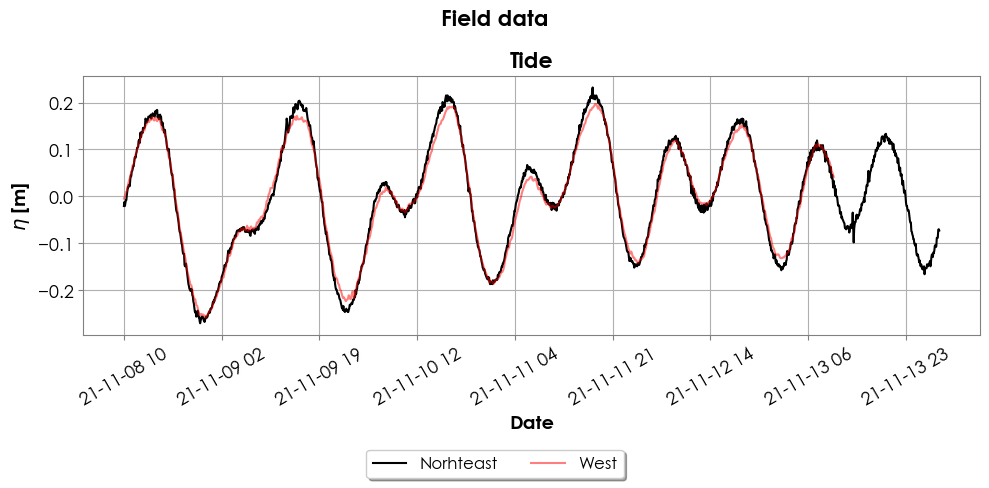

In [10]:
fig_tide(df1= df_wl_muelle, df2= df_wl_cove,variable='waterlevel', id1 = 'Norhteast', id2 = 'West', coef_tikslabels=200, rotation=30)

## Waves

In [11]:
def wavelength(T,h):
    '''
    Función para determinar la longitud de ola
    -----------
    Parametros de entrada
    T: Periodo de ola 
    h: Profunidad
    -----------
    Returns: 
    L1: Longitud de ola
    '''
    #Función que calcula L en aguas intermedias
    Lo = (9.81*T**2)/(2*np.pi);
    L1  = (9.81*T**2)/(2*np.pi)*np.tanh((h*2*np.pi)/Lo);
    i = 0;
    while (abs(Lo-L1)>0.0001):
        Lo = L1;
        L1  = (9.81*T**2)/(2*np.pi)*np.tanh(h*2*np.pi/Lo);
        i = i+1;
        if (i>5000):
            break
    return (L1)


def SpectraBurstOCEANLYZ(burst,fs,num_perseg_FFT,heightfrombed,fmin,fmax,maxcutoff,pressureattenuation,tailcorrection,tailpower):
    """  
    SpectraBurstOCEANLYZ
    ==============
    Hm0,Tm01,Tm02,Tp,fp,f,Syy=SpectraOCEANLYZ_burst(burst,fs,num_perseg_FFT,heightfrombed,fmin,fmax,maxcutoff,pressureattenuation,tailcorrection,tailpower)
    
    DESCRIPTION
    -----------
    Calculate wave properties from a depth burst using power spectral density

    INPUT
    -----
    burst=burst_depth  -------->    Water depth burst in (meters)
    fs=2  -------------------->     Sampling frequency that data collected at in (Hz)
    num_perseg_FFT=256 -------->    Number of elements in each segment window to perform the FFT. 
                                    Recommended: 256 for RBR - 128 for AQ. Overlap equals num_perseg_FFT/2 
                                    Longitude of frequencies array equal to num_perseg_FFT/2 + 1 
    heightfrombed=0.05 -------->    Sensor height from bed
    fmin=0.08 ----------------->    Minimum frequency for cut off the lower part of spectra
    fmax=0.95 ----------------->    Maximum frequency for cut off the upper part of spectra

    maxcutoff='on' ----------->     Define if to cut off the spectra beyond fmax
                                        maxcutoff='off': Cutoff off
                                        maxcutoff='on': Cutoff on

    pressureattenuation="all" ->    Define if to apply pressure attenuation factor or not
                                        pressureattenuation='off': No pressure attenuation applied
                                        pressureattenuation='on': Pressure attenuation applied without correction after fmaxpcorr
                                        pressureattenuation='all': Pressure attenuation applied with constant correction after fmaxpcorr

    tailcorrection='tma' ------>    Define if to apply diagnostic tail correction or not 
                                        tailcorrection='off': Not apply
                                        tailcorrection='jonswap': JONSWAP Spectrum tail  - deep water 
                                        tailcorrection='tma': TMA Spectrum tail - shallow and intermediate water
    tailpower=-4 -------------->    Power that diagnostic tail apply based on that (-3 for shallow water to -5 for deep water)

    OUTPUT
    ------
    Hm0 = Zero-Moment Wave Height (m)
    Tm01 = Wave Period from m01 (second), Mean Wave Period
    Tm02 = Wave Period from m02 (second), Mean Zero Crossing Period
    Tp = Peak Wave Period (second)
    fp = Peak Wave Frequency (Hz)
    f = Frequency (Hz)
    Syy = Wave Surface Elevation Power Spectrum (m^2/Hz)

    EXAMPLE

    Hm0,Tm01,Tm02,Tp,fp,f,Syy=SpectraOCEANLYZ_burst(water_pressure/(1000*9.81),2,256,0.05,0.08,0.95,1,'on','all','tma',-3)

    """

    #==========================================================================

    #CODE
    ## -------------------------------- Import required packages -------------------------------- ##

    import numpy as np
    import scipy as sp
    import pandas as pd
    from scipy import signal

    ## -------------------------------- Calculating spectral moments -------------------------------- ##

    input1=sp.signal.detrend(burst) # deterending
    f1, Syy_half = sp.signal.welch(input1,fs=fs,nperseg=num_perseg_FFT)    # Fast Fourier transform
    f1, Syy_half = f1[1:-1], Syy_half[1:-1] 
    Syy_half[f1 < fmin] = 0
    if maxcutoff=='on':
        Syy_half[f1>fmax]=0

    ## ------------------------------- Estimation of wave number (k) -------------------------------- ##

    h = burst.mean() + heightfrombed
    w = 2*np.pi*f1
    k = np.zeros(len(f1))
    for _ in range(len(f1)):
        k[_] = (2*np.pi)/wavelength(1/f1[_],h)
    k[w == 0] = 0

    ## -------------------------- Calculation of pressure response factor (Kp) ---------------------- ##

    Kp=np.cosh(k*heightfrombed)/np.cosh(k*h)
    kmaxL=np.pi/(h-heightfrombed) # Wave number associated with fmaxpcorrL
    KpminL=np.cosh(kmaxL*heightfrombed)/np.cosh(kmaxL*h) # Minimum Limit for K_p calculated based on linear wave theory
    fmaxpcorrL=1/(2*np.pi)*np.sqrt(9.81*kmaxL*np.tanh(kmaxL*h)) # Maximum frequency that K_p can be applied, calculated from linear wave theory
    Kp[Kp < KpminL] = KpminL # Check to avoid large amplification, Kp should be larger than minimum K_p calculated based on linear wave theory

    ## -------------------------- Automatically estimating fmaxpcorr and ftailcorrection ---------------------- ##

    fminpcorr = fmin
    locfminpcorr=int(np.max((np.nonzero(f1<=fminpcorr))[0])) #Locating the location of fminpcorr (fmaxpcorr should be larger than fminpcorr)
    locSyymax=np.argmax(Syy_half[locfminpcorr:]) # Locating the peak frequency, fp, of original dataset
    locfmaxpcorrL=int(np.max((np.nonzero(f1<=fmaxpcorrL))[0])) #Location the location of fmaxpcorr1
    if (locfmaxpcorrL<locfminpcorr+(locSyymax)): 
        locfmaxpcorrL=locfminpcorr+(locSyymax) #Check if locfmaxpcorrL located after fp
    Syy1=Syy_half/(Kp**2)
    locSyymin=np.argmin(Syy1[locfminpcorr+(locSyymax):locfmaxpcorrL+1]) #Locating the location of minimum value for Syy between fp and fmaxpcorr1
    locfmaxpcorr = locfminpcorr+(locSyymax)+(locSyymin)
    fmaxpcorr=f1[locfmaxpcorr] #Asigning the frequency of the location of minimum value for Syy between fp and fmaxpcorr1
    ftailcorrection=f1[locfminpcorr+(locSyymax)+(locSyymin)]
    if (fmaxpcorr>fmaxpcorrL): 
        fmaxpcorr=fmaxpcorrL #Check fmaxpcorr1 be smaller than fmaxpcorrL
        ftailcorrection=fmaxpcorrL
    if ((fmaxpcorrL>f1[locfminpcorr+(locSyymax)]) and (fmaxpcorr==f1[locfminpcorr+(locSyymax)]) ): 
        fmaxpcorr=fmaxpcorrL #if fmaxpcorrL>fp then fmaxpcorr1 should not be equal to fp

    ## ------------------------------------ Choice of correction method for Kp -------------------------------- ##     

    if pressureattenuation=='off':
            Kp[0:]=1

    elif pressureattenuation=='on':
        Kp[f1>fmaxpcorr]=1 # correction factor larger than fmaxpcorr should be 1 (no correction)
        # linear decrease of correction for f larger than maximum frequency
        loc1=int(np.max((np.nonzero(f1<=fmaxpcorr-0.05))[0]))
        loc2=int(np.max((np.nonzero(f1<=fmaxpcorr+0.05))[0]))
        if (loc2>len(f1)): loc2=len(f1)
        for i in range(loc1,loc2+1,1):
            Kp[i]=(Kp[loc2]-Kp[loc1])/(loc2-loc1)*(i-loc1)+Kp[loc1]

    elif pressureattenuation=='all':
        loc2=int(np.max((np.nonzero(f1<=fmaxpcorr))[0]))
        if (loc2>len(f1)): loc2=len(f1)
        Kp[f1>fmaxpcorr]=Kp[loc2] # correction factor larger than fmaxpcorr stays constant


    ## ----------------------------------------- Applying tail correction ------------------------------------- ## 

    Syy = Syy_half/Kp**2
    f = f1
    deltaf = f[1]-f[0]

    #Index of ftailcorrection
    if tailcorrection=='jonswap' or tailcorrection=='tma':
        Indxftail=int(np.min((np.nonzero(f>=ftailcorrection))[0]))

    #Applying diagnostic frequency tail based on JONSWAP after fmax
    if tailcorrection=='jonswap':
        
        Syy[f>ftailcorrection]=Syy[Indxftail]*(f[f>ftailcorrection]/ftailcorrection)**tailpower #Adding diagnostic tail
        Syy[Syy<0]=0 #Syy can not be negative

    #Applying diagnostic frequency tail based on TMA after fmax
    elif tailcorrection=='tma':
        
        omega=2*np.pi*f*np.sqrt(h/9.81)

        #Transformation function from JONSWAP into TMA, approximated method
        PHI=np.ones(len(omega))
        PHI[omega<=1]=omega[omega<=1]**2/2
        PHI[((omega>1) & (omega<2))]=1-0.5*(2-omega[((omega>1) & (omega<2))])**2
        PHI[omega>=2]=1
        
        Syy[f>ftailcorrection]=Syy[Indxftail]*(PHI[f>ftailcorrection]/PHI[Indxftail])*(f[f>ftailcorrection]/ftailcorrection)**tailpower #Adding TMA Spectrum tail
        Syy[Syy<0]=0 #Syy can not be negative

    ## ---------------------------- Calculating spectral moments and wave properties ------------------------ ## 

    m0=np.sum(Syy*f**0*deltaf)
    m1=np.sum(Syy*f**1*deltaf)
    m2=np.sum(Syy*f**2*deltaf)

    #calculating wave properties
    Hm0=4.004*np.sqrt(m0) #Zero-Moment wave height
    Tm01=m0/m1 #mean period
    Tm02=(m0/m2)**0.5 #zero crossing period

    #calculation peak period
    loc4=np.argmax(Syy)
    Tp=1/f[loc4] #peak period

    #calculating peak frequency from weighted integral (Young, 1995)
    fp=(np.sum(Syy**5*f**1*deltaf))/(np.sum(Syy**5*f**0*deltaf)) #peak frequency

    ## ----------------------------------------------- Outputs ------------------------------------------- ## 

    return Hm0,Tm01,Tm02,Tp,fp,f,Syy

    ## -----------------------------------------------          ------------------------------------------- ##


def SpectraSeriesOCEANLYZ(df,duration,fs,num_perseg_FFT,heightfrombed,fmin,fmax,maxcutoff,pressureattenuation,tailcorrection,tailpower):

    """  
    SpectraSeriesOCEANLYZ
    ==============
    Hm0,Tm01,Tm02,Tp,fp,f,Syy=SpectraOCEANLYZ_burst(burst,fs,num_perseg_FFT,heightfrombed,fmin,fmax,maxcutoff,pressureattenuation,tailcorrection,tailpower)
    
    DESCRIPTION
    -----------
    Calculate wave properties from a depth burst using power spectral density

    INPUT
    -----
    df=df_RBR  ---------------->    Clean dataframe with times, pressure and depth (Index=Time - Cols = Pres, Depth)
    duration=1024  ------------>    Duration time that data collected in input in each burst in (second) 
    fs=2  -------------------->     Sampling frequency that data collected at in (Hz)
    num_perseg_FFT=256 -------->    Number of elements in each segment window to perform the FFT. 
                                    Recommended: 256 for RBR - 128 for AQ. Overlap equals num_perseg_FFT/2 
                                    Longitude of frequencies array equal to num_perseg_FFT/2 + 1 
    heightfrombed=0.05 -------->    Sensor height from bed
    fmin=0.08 ----------------->    Minimum frequency for cut off the lower part of spectra
    fmax=0.95 ----------------->    Maximum frequency for cut off the upper part of spectra

    maxcutoff='on' ----------->     Define if to cut off the spectra beyond fmax
                                        maxcutoff='off': Cutoff off
                                        maxcutoff='on': Cutoff on

    pressureattenuation="all" ->    Define if to apply pressure attenuation factor or not
                                        pressureattenuation='off': No pressure attenuation applied
                                        pressureattenuation='on': Pressure attenuation applied without correction after fmaxpcorr
                                        pressureattenuation='all': Pressure attenuation applied with constant correction after fmaxpcorr

    tailcorrection='tma' ------>    Define if to apply diagnostic tail correction or not 
                                        tailcorrection='off': Not apply
                                        tailcorrection='jonswap': JONSWAP Spectrum tail  - deep water 
                                        tailcorrection='tma': TMA Spectrum tail - shallow and intermediate water
    tailpower=-4 -------------->    Power that diagnostic tail apply based on that (-3 for shallow water to -5 for deep water)

    OUTPUT
    ------
    Hm0 = Zero-Moment Wave Height (m)
    Tm01 = Wave Period from m01 (second), Mean Wave Period
    Tm02 = Wave Period from m02 (second), Mean Zero Crossing Period
    Tp = Peak Wave Period (second)
    fp = Peak Wave Frequency (Hz)
    f = Frequency (Hz)
    Syy = Wave Surface Elevation Power Spectrum (m^2/Hz)

    EXAMPLE

    dict_waveparms=SpectraSeriesOCEANLYZ(df_RBR,1024,2,256,0.05,0.08,0.95,1,'on','all','tma',-3)

    """

    #==========================================================================

    #CODE
    ## -------------------------------- Import required packages --------------------------------- ##

    import numpy as np
    import scipy as sp
    import pandas as pd
    from scipy import signal
    
    ## ---------------------------------- Create arrays to fill ---------------------------------- ##

    Hm0 = np.zeros(int(df.shape[0]/(duration*fs)))
    Tm01 = np.copy(Hm0)
    Tm02 = np.copy(Hm0)
    Tp = np.copy(Hm0)
    fp = np.copy(Hm0)
    f = np.zeros([int(df.shape[0]/(duration*fs)),int((num_perseg_FFT/2)-1)])
    Syy = np.copy(f)

    time_bursts = df.index[0:-1:duration*fs]
    depth_burst = df["Depth"].values.reshape(int(df.shape[0]/(duration*fs)),int(duration*fs)).T

    for _ in range(len(time_bursts)):
      # print(_)
      data_burst = SpectraBurstOCEANLYZ(depth_burst[:,_],fs,num_perseg_FFT,heightfrombed,fmin,fmax,maxcutoff,pressureattenuation,tailcorrection,tailpower)
      Hm0[_] = data_burst[0]
      Tm01[_] = data_burst[1]
      Tm02[_] = data_burst[2]
      Tp[_] = data_burst[3]
      fp[_] = data_burst[4]
      f[_,:] = data_burst[5]
      Syy[_,:] = data_burst[6]

    wave_prop = {"Hm0":Hm0,"Tm01":Tm01,"Tm02":Tm02,"Tp":Tp,"fp":fp,"f":f,"Syy":Syy,"Times":time_bursts}         

    ## ------------------------------------------ Outputs -------------------------------------- ## 

    return wave_prop

    ## ------------------------------------------          -------------------------------------- ##


def fig_waves(dic1, dic2, variable, sensor1, sensor2,coef_tikslabels ,rotation):
    """
    Inputs: 
    - dic1: diccionario del sensor 1
    - dic2: diccionario del sensor 2
    - variable: variable a dibujar 'Hm0'/'Tp'
    - sensor1 : nombre del punto uno
    - sensor2: nombre del putno 2
    - coef_tickslabels: coeficiente para distribur los tickslabels del tiempo
    - rotation: angulo de rotación en deg para ajustar los tickslabels
    -------------------------------------------------------------------
    Outputs: 
    - figuras 
    """
    fig, ax = plt.subplots(figsize = (10, 3))

    ticklabels = dic1['Times'][::coef_tikslabels]
    ax.set_xticks(ticklabels)
    date_format = mdates.DateFormatter('%y-%m-%d %H')
    ax.xaxis.set_major_formatter(date_format)
    if variable ==  'Hm0':
        ax.plot(dic1['Times'], dic1[variable], label = sensor1, ls = '-', color ='#8ABB73', lw = 2 )
        ax.plot(dic2['Times'], dic2[variable], label = sensor2, ls = '-', c ='#22467F', lw = 2 )
        title = 'Significant wave height'
        name_label = 'H$_{mo}$ [m]'
    elif variable == 'Tp':
        ax.plot(dic1['Times'], dic1[variable],label=sensor1, color ='#8ABB73', lw = 1.5, ls = '--')
        ax.plot(dic2['Times'], dic2[variable],label=sensor2,c ='#22467F', lw = 1.5, ls = '--')
        title = 'Peak period'
        name_label = 'T$_p$ [seg]'
    ax.set_xlabel('Date', size = 14, fontweight = 'bold')
    ax.set_ylabel(name_label, size = 14, fontweight = 'bold')
    ax.set_title(title, size = 16, fontweight = 'bold')   
    fig_params(ax)
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize = 12)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.subplots_adjust(hspace=0.1)
    plt.xticks(rotation=rotation);

In [12]:
# AW600 
paths_aw600 = glob.glob(r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC600\*.wad")
paths_aw600 = sorted(paths_aw600)
df_aw600, time_aw600, hdt_aw600 = class_field_db_AW600.waves(paths=paths_aw600, samples= 1024, fecha_inicio=datetime.datetime(2021,11,6,11,0,0), fecha_fin=datetime.datetime(2021,11,14,3,0,0), fecha_ideploid= datetime.datetime(2021,11,6,11,0,0), fecha_fdeploid=datetime.datetime(2021,11,14,7,0,0))
df_aw600 = df_aw600[:-1]
#AW1000
paths_aw1000 = glob.glob(r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC1000\*.wad")
paths_aw1000 = sorted(paths_aw1000) [2:-6] # Se eliminan los primeros burst donde el sensor estuvo por fuera del agua
df_aw1000, time_aw1000, hdt_aw1000  = class_field_db_AW1000. waves(paths=paths_aw1000, samples= 2048, fecha_inicio=datetime.datetime(2021,11,6,13,0,0), fecha_fin=datetime.datetime(2021,11,14,3,0,0), fecha_ideploid= datetime.datetime(2021,11,6,9,0), fecha_fdeploid=datetime.datetime(2021,11,14,8,59,59))
df_aw1000 = df_aw1000[:-1]

dic_AW600 = SpectraSeriesOCEANLYZ(df = df_aw600['Depth'].to_frame('Depth'), duration= 1024, fs = 1, num_perseg_FFT= 64, heightfrombed= 1.2, fmin= 0.03, fmax = 0.5, maxcutoff= 'off', pressureattenuation='all', tailcorrection='off', tailpower= -3)
dic_AW1000 = SpectraSeriesOCEANLYZ(df = df_aw1000['Depth'].to_frame('Depth'), duration= 1024, fs = 2, num_perseg_FFT= 256, heightfrombed= 1, fmin= 0.03, fmax = 0.5, maxcutoff= 'off', pressureattenuation='all', tailcorrection='off', tailpower= -3)

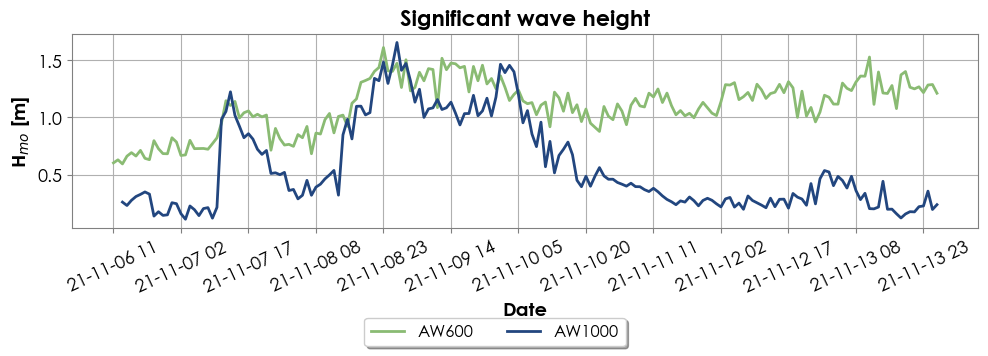

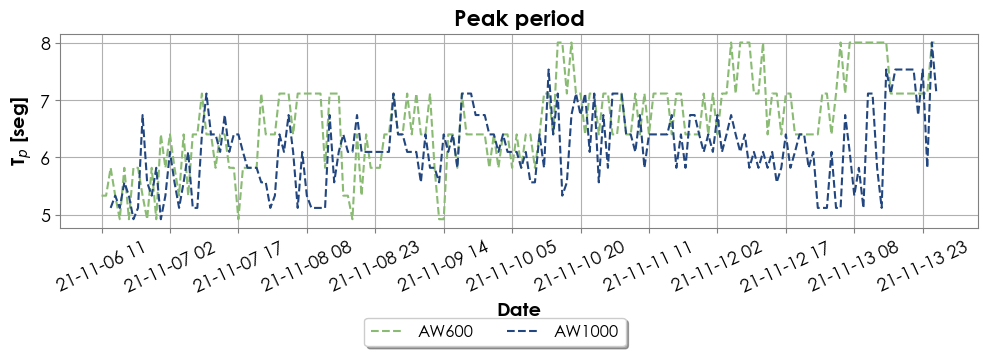

In [13]:
fig_waves(dic1= dic_AW600, dic2=dic_AW1000, variable='Hm0', sensor1='AW600', sensor2= 'AW1000', coef_tikslabels= 15, rotation=25 )
fig_waves(dic1= dic_AW600, dic2=dic_AW1000, variable='Tp', sensor1='AW600', sensor2= 'AW1000', coef_tikslabels= 15, rotation=25 )

### Analisis Espectral

In [14]:
Vec_Energy_AW600 = np.zeros(shape = (dic_AW600['Times'].shape))
Vec_Energy_AW1000 = np.zeros(shape = (dic_AW1000['Times'].shape))
for i, j in zip (np.arange(0,len(Vec_Energy_AW600),1),np.arange(0,len(Vec_Energy_AW1000),1)):
    Vec_Energy_AW600[i] = (1025*9.81)*np.sum(dic_AW600['Syy'][i,:]*np.diff(dic_AW600['f'][i,:])[0])
    Vec_Energy_AW1000[i] = (1025*9.81)*np.sum(dic_AW1000['Syy'][i,:]*np.diff(dic_AW1000['f'][i,:])[0])

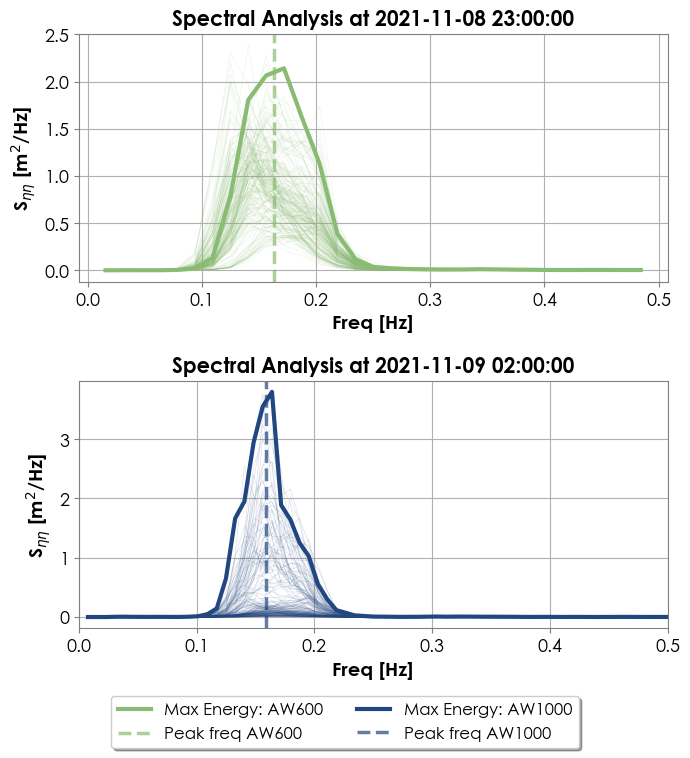

In [15]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(7,7))
for i in range(len(dic_AW600['Times'])):
    if i == np.argmax(Vec_Energy_AW600):
        ax1.plot(dic_AW600['f'][i, :], dic_AW600['Syy'][i, :],label='Max Energy: AW600', ls = '-', color ='#8ABB73', lw = 3)
        ax1.axvline(dic_AW600['fp'][i], color ='#8ABB73',label = 'Peak freq AW600', ls = '--', lw = 2.5, alpha = 0.7)
        # ax1.axvline(dic_AW600['f'][0,10], color ='#70AFBA', ls = ':', lw = 1.5, alpha = 1)
        # ax1.axvline(dic_AW600['f'][0,35], color ='#70AFBA', ls = ':', lw = 1.5, alpha = 1)

        ax1.set_title('Spectral Analysis at '+ str(dic_AW600['Times'][i]) ,size=15, fontweight= 'semibold')
    else:
        ax1.plot(dic_AW600['f'][i, :], dic_AW600['Syy'][i, :], ls = '-', color ='#8ABB73', lw = 0.5, alpha = 0.15)

for i in range(len(dic_AW1000['Times'])):
    if i == np.argmax(Vec_Energy_AW1000):
        ax2.plot(dic_AW1000['f'][i, :], dic_AW1000['Syy'][i, :],label='Max Energy: AW1000', ls = '-',c ='#22467F', lw = 3)
        ax2.axvline(dic_AW1000['fp'][i], c ='#22467F',label = 'Peak freq AW1000' ,ls = '--', lw = 2.5, alpha = 0.7)
        # ax2.axvline(dic_AW1000['f'][0,10], color ='#70AFBA', label = 'Min Freq',ls = ':', lw = 1.5, alpha = 1)
        # ax2.axvline(dic_AW1000['f'][0,35], color ='#70AFBA', label = 'Max Freq',ls = ':', lw = 1.5, alpha = 1)
        ax2.set_title('Spectral Analysis at '+ str(dic_AW1000['Times'][i]) ,size=15, fontweight= 'semibold')

    else:
        ax2.plot(dic_AW1000['f'][i, :], dic_AW1000['Syy'][i, :], ls = '-',c ='#22467F', lw = 0.5, alpha = 0.15)
    # ax1.axvline(dic_AW600['fp'][i], color ='#8ABB73', ls = '--', lw = 2.5, alpha = 0.5)
ax1.set_ylabel('S$_{\eta\eta}$ [m$^2$/Hz]',size=14, fontweight = 'semibold')
ax1.set_xlabel('Freq [Hz]',size=14, fontweight = 'semibold')
fig_params(ax1)


ax2.set_xlabel('Freq [Hz]',size=14, fontweight = 'semibold')
ax2.set_ylabel('S$_{\eta\eta}$ [m$^2$/Hz]',size=14, fontweight = 'semibold')
ax2.set_xlim([0, 0.5])
fig_params(ax2)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.01),
          fancybox=True, shadow=True, ncol=2, fontsize = 12)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.4)

In [16]:
def Onditas_Continuas(serie, delta_time):

    x = serie
    fechas = x.index

    import pandas as pd
    import numpy as np
    import pycwt as wavelet
    from pycwt.helpers import find

    data_inicio = serie.index[0].year
    data_fin = serie.index[-1].year

    s = np.array(x)
    t = np.linspace(0, len(s)*delta_time, len(x))
    dt = np.diff(t)[0]
    n = t.size

    # Calculate the CWT of both time series. The function wavelet.cwt

    mother = wavelet.Morlet(6.)         # Morlet mother wavelet with m=6
    slevel = 0.95                       # Significance level
    dj     = 1/12.                      # Twelve sub-octaves per octaves
    s0     = 20*dt                      # Starting scale
    J      = 7/dj                       # Seven powers of two with dj sub-octaves

    if True:
        alpha, _, _ = wavelet.ar1(s)  # Lag-1 autocorrelation for red noise
    else:
        alpha = 0.0                    # Lag-1 autocorrelation for white noise

    #The following routines perform the wavelet transform and siginificance
    W, scales, freqs, coi, _, _ = wavelet.cwt(s, dt, dj, s0, J, mother)
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha, significance_level = slevel, wavelet = mother)

    power = (np.abs(W)) ** 2            # Power spectrum
    period = 1/freqs
    sig95 = np.ones([1, n]) * signif[:, None]
    sig95 = power/sig95               # Where ratio > 1, power is significant

    return power, sig95, period, coi, fechas

#Función para graficar el espectro de onditas
def GraficaOnditas(power, period, sig95, coi, fechas, ruta_save):

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    period = period*365

    csfont = {'fontname':'serif', 'size':16,'weight' : 500}
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 16
    plt.rcParams["figure.titleweight"] = 'normal'

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1, 1, 1)

    a = np.min(power)
    b = np.nanmean(power[:np.where(period>=160)[0][0]])*3.5
    bounds = np.arange(a, b, (b-a)/100.)

    plt.contourf(fechas, period, power, len(bounds), cmap = plt.cm.jet, levels = bounds, extend = 'max')
    plt.colorbar(format ='%1.f').set_label(u'Potencia', **csfont)

    plt.xlim(fechas[0], fechas[-1])
    plt.ylim([np.min(period), np.max(period)])
    plt.xticks(rotation=90)
    plt.ylabel(u'Frecuencia (días)', **csfont)
    ax.set_yscale('log', base=2, subs=None)

    yticks=[[30,60,90,180,365,1460], [30,60,90,180,365,1460]]
    plt.yticks(yticks[0], yticks[1])

    axx = plt.gca().yaxis
    axx.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    ax.invert_yaxis()

    plt.contour(fechas, period, sig95, [1, 99], colors='k')

    delta = fechas[1] - fechas[0]
    plt.fill(np.concatenate([fechas, fechas[-1:]+delta, fechas[-1:]+delta, fechas[:1]-delta, fechas[:1]-delta]), 
             np.concatenate([coi*365, [1e-9], period[-1:], period[-1:], [1e-9]]),
             'w', alpha=0.6, hatch='x', edgecolor='dimgray')
    # plt.savefig(ruta_save, bbox_inches='tight', dpi = 200)
    plt.show()
    plt.close()

In [17]:
len(dic_AW600['Hm0'])

184

In [18]:
(1/24)/7.625

0.00546448087431694

In [127]:
1/184

0.005434782608695652

In [116]:
(dic_AW600['Times'][-1]-dic_AW600['Times'][0]).days + 15/24

7.625

In [49]:
1*1/24

0.041666666666666664

In [82]:
power, sig95, period, coi, fechas =Onditas_Continuas(pd.Series(dic_AW600['Hm0'], index=dic_AW600['Times']), 1)

In [74]:
np.mean(power[:np.where(period >= 1)[0][0]])

0.12101807659587574

In [84]:
period

array([  20.7737739 ,   22.00904678,   23.3177728 ,   24.70431973,
         26.17331502,   27.72966132,   29.37855279,   31.12549245,
         32.97631054,   34.93718401,   37.01465708,   39.21566312,
         41.5475478 ,   44.01809356,   46.63554561,   49.40863945,
         52.34663004,   55.45932265,   58.75710558,   62.2509849 ,
         65.95262108,   69.87436802,   74.02931415,   78.43132625,
         83.0950956 ,   88.03618711,   93.27109121,   98.81727891,
        104.69326009,  110.91864529,  117.51421116,  124.50196979,
        131.90524217,  139.74873603,  148.05862831,  156.86265249,
        166.1901912 ,  176.07237422,  186.54218242,  197.63455782,
        209.38652018,  221.83729059,  235.02842233,  249.00393958,
        263.81048434,  279.49747206,  296.11725662,  313.72530499,
        332.3803824 ,  352.14474844,  373.08436485,  395.26911564,
        418.77304036,  443.67458117,  470.05684466,  498.00787917,
        527.62096868,  558.99494412,  592.23451323,  627.45060

In [85]:
np.arange(a, b, (b-a)/100)

ValueError: arange: cannot compute length

In [77]:
power

array([[2.20542458e-01, 2.26814340e-01, 2.32516272e-01, ...,
        3.68294059e-01, 3.80876364e-01, 3.91228931e-01],
       [2.62046620e-01, 2.70138423e-01, 2.77625039e-01, ...,
        3.73956304e-01, 3.86525299e-01, 3.96998283e-01],
       [2.89734225e-01, 2.99056131e-01, 3.07797215e-01, ...,
        4.12096825e-01, 4.22942593e-01, 4.31778971e-01],
       ...,
       [1.17475718e-12, 1.17475718e-12, 1.17475718e-12, ...,
        1.17475718e-12, 1.17475718e-12, 1.17475718e-12],
       [1.24461188e-12, 1.24461188e-12, 1.24461188e-12, ...,
        1.24461188e-12, 1.24461188e-12, 1.24461188e-12],
       [1.31862035e-12, 1.31862035e-12, 1.31862035e-12, ...,
        1.31862035e-12, 1.31862035e-12, 1.31862035e-12]])

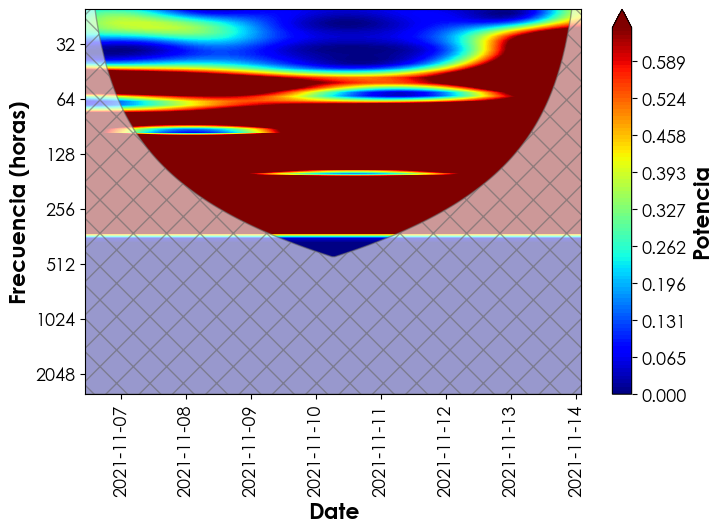

In [87]:
import matplotlib.ticker as ticker

# csfont = {'fontname':'serif', 'size':16,'weight' : 500}

fig, ax = plt.subplots(figsize = (8,5))
a = np.min(power)
# b = np.max(power)
b = np.nanmean(power[:np.where(period >= 30)[0][0]])*3.5
bounds = np.arange(a, b, (b-a)/100)
cb = ax.contourf(fechas, period, power, len(bounds), cmap = plt.cm.jet, levels = bounds, extend = 'max')
plt.colorbar(cb, format ='%1.3f').set_label('Potencia', size = 16, fontweight = 'semibold')
ax.set_xlim(fechas[0], fechas[-1])
ax.set_ylim([np.min(period), np.max(period)])

ax.set_ylabel('Frecuencia (horas)', size = 16, fontweight = 'semibold')
ax.set_xlabel('Date', size = 16, fontweight = 'semibold')


ax.set_yscale('log', base=2, subs=None)
axx = plt.gca().yaxis
axx.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
ax.invert_yaxis()

# plt.contour(fechas, period, sig95, [1, 99], colors='k')

delta = fechas[1] - fechas[0]
plt.fill(np.concatenate([fechas, fechas[-1:]+delta, fechas[-1:]+delta, fechas[:1]-delta, fechas[:1]-delta]), 
            np.concatenate([coi*7, [1e-9], period[-1:], period[-1:], [1e-9]]),
            'w', alpha=0.6, hatch='x', edgecolor='dimgray')
plt.xticks(rotation=90);


In [48]:
def GraficaOnditas(power, period, sig95, coi, fechas, ruta_save):

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    period = period*360

    csfont = {'fontname':'serif', 'size':16,'weight' : 500}
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 16
    plt.rcParams["figure.titleweight"] = 'normal'

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1, 1, 1)

    a = np.min(power)
    b = np.nanmean(power[:np.where(period>=160)[0][0]])*3.5
    bounds = np.arange(a, b, (b-a)/100.)

    plt.contourf(fechas, period, power, len(bounds), cmap = plt.cm.jet, levels = bounds, extend = 'max')
    plt.colorbar(format ='%1.f').set_label(u'Potencia', **csfont)

    plt.xlim(fechas[0], fechas[-1])
    plt.ylim([np.min(period), np.max(period)])
    plt.xticks(rotation=90)
    plt.ylabel(u'Frecuencia (días)', **csfont)
    ax.set_yscale('log', base=2, subs=None)

    yticks=[[30,60,90,180,365,1460], [30,60,90,180,365,1460]]
    plt.yticks(yticks[0], yticks[1])

    axx = plt.gca().yaxis
    axx.set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(axis='y', style='plain')
    ax.invert_yaxis()

    plt.contour(fechas, period, sig95, [1, 99], colors='k')

    delta = fechas[1] - fechas[0]
    plt.fill(np.concatenate([fechas, fechas[-1:]+delta, fechas[-1:]+delta, fechas[:1]-delta, fechas[:1]-delta]), 
             np.concatenate([coi*365, [1e-9], period[-1:], period[-1:], [1e-9]]),
             'w', alpha=0.6, hatch='x', edgecolor='dimgray')
    # plt.savefig(ruta_save, bbox_inches='tight', dpi = 200)
    plt.show()
    plt.close()

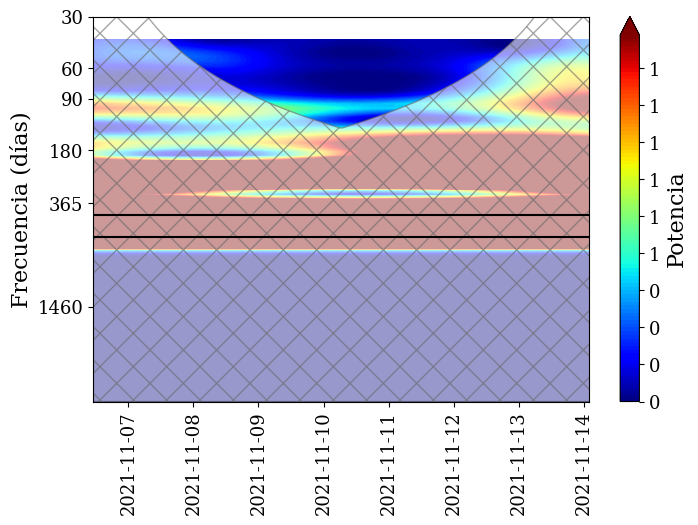

In [131]:
ruta_save = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
GraficaOnditas(power, period, sig95, coi, fechas, ruta_save)